# SRE Agent

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [10]:
from langchain_openai import ChatOpenAI
gpt5 = ChatOpenAI(model="gpt-5")
gpt5mini = ChatOpenAI(model="gpt-5-mini")

## Data structure

In [9]:
from typing import TypedDict, List, Literal, Optional

# Kubernetes problem
class K8SProblem(TypedDict):
    """Represents a Kubernetes problem."""
    type: Literal["symptom", "root_cause"]
    resource: str
    namespace: str
    issue: str
    description: str
    fix_suggestion: str

# Agent state
class AgentState(TypedDict):
    status: Literal["investigating", "found_issue", "completed"] # Used to manage the agent's flow
    problems_found: List[K8SProblem]
    suggestions: List[str]
    investigation_steps: List[str]

## Investigation steps

1. **Discover Phase**: Inspect the K8s cluster, find all problems across namespaces using K8S MCP server
2. **Filter Phase**: Identify which problems are symptoms vs root causes  
3. **Focus Phase**: Deep-dive into the main problematic resource using K8S MCP server
4. **Diagnose Phase**: Determine the single root cause of the issue
5. **Report Phase**: Output final diagnosis with clear fix for THE problem

In [ ]:
def initialize_agent_state() -> AgentState:
    return {
        "status": "investigating",
        "problems_found": [],
        "suggestions": [],
        "investigation_steps": []
    }

# MCP Client for Kubernetes

MCP K8s server: [mcp-server-kubernetes](https://github.com/Flux159/mcp-server-kubernetes)

In [16]:
from langchain_mcp_adapters.client import MultiServerMCPClient

client = MultiServerMCPClient(
    {
        "kubernetes" : {
            "command": "npx",
            "args": ["mcp-server-kubernetes"],
            "transport": "stdio",
            "env": {
                "ALLOW_ONLY_NON_DESTRUCTIVE_TOOLS": "true"
            }
        }
    }
)

# NB: The cluster has to be running otherwise the tools won't be available
tools = await client.get_tools()

In [17]:
#list all the tools
for tool in tools:
    print(f"🔧 {tool.name}: {tool.description}")

🔧 kubectl_get: Get or list Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_describe: Describe Kubernetes resources by resource type, name, and optionally namespace
🔧 kubectl_apply: Apply a Kubernetes YAML manifest from a string or file
🔧 kubectl_create: Create Kubernetes resources using various methods (from file or using subcommands)
🔧 kubectl_logs: Get logs from Kubernetes resources like pods, deployments, or jobs
🔧 kubectl_scale: Scale a Kubernetes deployment
🔧 kubectl_patch: Update field(s) of a resource using strategic merge patch, JSON merge patch, or JSON patch
🔧 kubectl_rollout: Manage the rollout of a resource (e.g., deployment, daemonset, statefulset)
🔧 kubectl_context: Manage Kubernetes contexts - list, get, or set the current context
🔧 explain_resource: Get documentation for a Kubernetes resource or field
🔧 install_helm_chart: Install a Helm chart
🔧 upgrade_helm_chart: Upgrade a Helm release
🔧 port_forward: Forward a local port to a port on a

## React agent (baseline)

In [25]:
llm_with_tools = gpt5mini.bind_tools(tools, parallel_tool_calls=False)

from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with retrievering info a kubernetes kluster.")

# Node
async def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

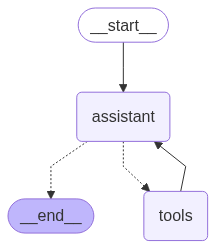

In [26]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [33]:
import time

async def test_async_graph(human_message: str):
    """Test the graph with proper async execution"""
    # Create a human message from the input
    messages = [HumanMessage(content=human_message)]
    
    # Start time tracking
    start_time = time.time()
    
    # Invoke the graph asynchronously
    result = await react_graph.ainvoke({"messages": messages})
    
    # Calculate execution time
    execution_time = time.time() - start_time
    
    # Print results
    for m in result['messages']:
        m.pretty_print()
    
    # Calculate token usage
    total_tokens = 0
    input_tokens = 0
    output_tokens = 0
    
    for m in result['messages']:
        if hasattr(m, 'usage_metadata'):
            if m.usage_metadata:
                if 'input_tokens' in m.usage_metadata:
                    input_tokens += m.usage_metadata['input_tokens']
                if 'output_tokens' in m.usage_metadata:
                    output_tokens += m.usage_metadata['output_tokens']
                if 'total_tokens' in m.usage_metadata:
                    total_tokens += m.usage_metadata['total_tokens']
    
    print(f"\nExecution time: {execution_time:.2f} seconds")
    print(f"Token usage: {total_tokens} total ({input_tokens} input, {output_tokens} output)")
    
    return result

In [35]:
human = "could you list all the pods in the namespaces and provide the status? Please add a summary of the system status"
result = await test_async_graph(human)

================================ Human Message =================================

could you list all the pods in the namespaces and provide the status? Please add a summary of the system status
================================== Ai Message ==================================
Tool Calls:
  kubectl_get (call_WAjQ4pTRMBfp1CFeYLN2034L)
 Call ID: call_WAjQ4pTRMBfp1CFeYLN2034L
  Args:
    resourceType: pods
    name: 
    namespace: 
    allNamespaces: True
    output: json
================================= Tool Message =================================
Name: kubectl_get

{
  "items": [
    {
      "name": "coredns-668d6bf9bc-nv4zf",
      "namespace": "kube-system",
      "kind": "Pod",
      "status": "Running",
      "createdAt": "2025-08-17T12:41:41Z"
    },
    {
      "name": "coredns-668d6bf9bc-z2kpt",
      "namespace": "kube-system",
      "kind": "Pod",
      "status": "Running",
      "createdAt": "2025-08-17T12:41:41Z"
    },
    {
      "name": "etcd-kind-control-plane",
      "n